# Project 5: Customer Segmentation with Clustering 🛍️

**Project Objective:** To use unsupervised machine learning to identify distinct groups of customers within a mall's dataset. By segmenting customers based on multiple dimensions (income, age, spending habits), we can provide rich, actionable insights to the marketing team for highly targeted campaigns.


### Core Concepts We'll Cover:
1.  **Unsupervised Learning:** Understanding the difference between supervised and unsupervised learning.
2.  **Clustering Fundamentals & K-Means:** A deep dive into how the K-Means algorithm works.
3.  **The Elbow Method:** A critical technique for finding the optimal number of clusters (`k`).
4.  **Multi-dimensional EDA:** Exploring relationships between all features using 2D and 3D plots.
5.  **Multiple Segmentation Models:** Building and interpreting different clustering models based on different feature sets.
6.  **Hierarchical Clustering:** A brief introduction to an alternative clustering method.
7.  **Data-Driven Personas:** Translating cluster statistics into actionable business strategies.

### **Theoretical Concept: What is Unsupervised Learning?**

So far, we have worked with **supervised learning**, where our datasets had a specific target variable we were trying to predict (e.g., `SalePrice`, `Survived`). The model *learns* the relationship between features and the known target.

**Unsupervised learning** is different. Here, we work with datasets that **do not have a target variable**. The goal is not to predict a known outcome, but to discover hidden patterns, structures, and relationships within the data itself.

**Clustering** is the most common type of unsupervised learning. The objective is to group data points into clusters, such that points within the same cluster are very similar to each other, and points in different clusters are very dissimilar.


### Step 1: Setup - Importing Libraries and Loading Data

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.cluster.hierarchy as sch

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Set plot style
sns.set_style('whitegrid')

Imagine you have a bunch of unsorted toys (your data points) and you want to group them into different boxes (your clusters) based on how similar they are. K-Means is like a helper that does this for you!

K-Means Algorithm: Grouping the Toys

* Choose how many boxes you want (Choose k): You decide beforehand how many groups you want to create. Let's say you want 3 boxes (so k=3).
* Place some "toy leaders" in the boxes (Initialize centroids): K-Means randomly picks 3 toys and places one in each box. These toys are the "leaders" or "centroids" of their boxes for now.
* Sort the toys by how close they are to the leaders (Assign points to clusters): K-Means looks at every single toy and figures out which "toy leader" it's closest to. It then puts each toy into the box with the closest leader.
* Find the new average location of the leaders (Update centroids): Once all the toys are in boxes, K-Means calculates the average location of all the toys in each box. These average locations become the new "toy leaders" or centroids.
* Repeat steps 3 and 4 until the leaders stop moving (Iterate until convergence): K-Means keeps repeating the sorting and leader-finding steps. It does this until the "toy leaders" don't move much anymore, meaning the groups are stable.
Once the algorithm stops, you have your toys sorted into k boxes (clusters), where the toys in each box are generally similar to each other.

In [56]:
# Load the dataset from the user-provided file
#!git clone "https://github.com/GeeksforgeeksDS/21-Days-21-Projects-Dataset"
df = pd.read_csv('/Users/satta/Downloads/21-Days-21-Projects-Dataset/Datasets/Mall_Customers.csv')

print("Dataset loaded successfully.")
print(f"Data shape: {df.shape}")
df.head()

Dataset loaded successfully.
Data shape: (200, 5)


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


### Step 2: In-Depth Exploratory Data Analysis (EDA)
Before clustering, we must understand the features and their relationships to find the most promising dimensions for segmentation.

In [57]:
# Basic info and statistics
print("Dataset Info:")
df.info()

# Drop the CustomerID as it's just an identifier and not useful for clustering
df.drop('CustomerID', axis=1, inplace=True)

print("\nDescriptive Statistics:")
print(df.describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB

Descriptive Statistics:
              Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000          200.000000              200.000000
mean    38.850000           60.560000               50.200000
std     13.969007           26.264721               25.823522
min     18.000000           15.000000                1.000000
25%     28.750000           41.500000               34.750000
50%     36.000000           61.500000               50.000000
75%     4

#### 2.1 Univariate Analysis (Feature Distributions)

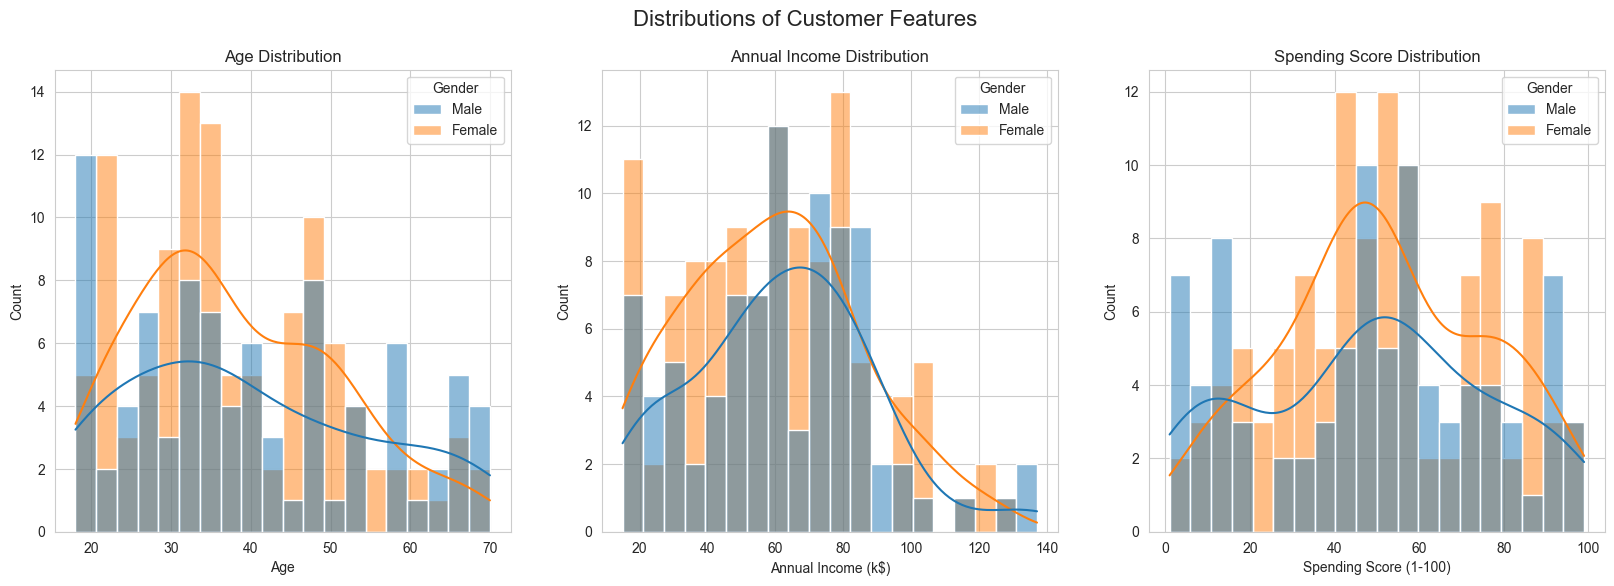

In [58]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Distributions of Customer Features', fontsize=16)

sns.histplot(ax=axes[0], data=df, x='Age', kde=True, bins=20, hue='Gender').set_title('Age Distribution')
sns.histplot(ax=axes[1], data=df, x='Annual Income (k$)', kde=True, bins=20, hue='Gender').set_title('Annual Income Distribution')
sns.histplot(ax=axes[2], data=df, x='Spending Score (1-100)', kde=True, bins=20, hue='Gender').set_title('Spending Score Distribution')

plt.show()

#### 2.2 Bivariate Analysis (Looking for Relationships)

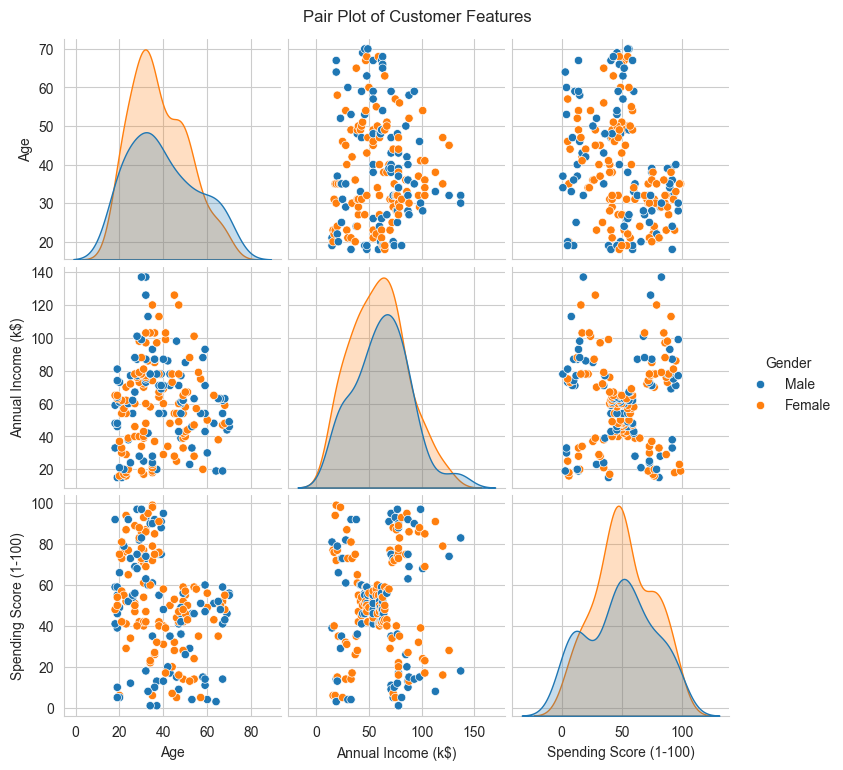

In [59]:
# Using pairplot to visualize relationships between all numerical variables
sns.pairplot(df, vars=['Age', 'Annual Income (k$)', 'Spending Score (1-100)'], hue='Gender', diag_kind='kde')
plt.suptitle('Pair Plot of Customer Features', y=1.02)
plt.show()

**CRITICAL INSIGHT from Pair Plot:**
- The **`Annual Income` vs. `Spending Score`** plot is the most revealing. It clearly shows distinct, blob-like groups, making it the perfect candidate for clustering.
- The **`Age` vs. `Spending Score`** plot shows some patterns but they are less defined. We see a concentration of high-spending customers in the younger age brackets.
- `Gender` does not appear to be a strong separating factor in any of these plots, as the distributions for males and females largely overlap.

#### 2.3 3D Visualization
Let's visualize the three most important features together in an interactive 3D plot to see if the clusters hold up.

In [8]:
!python3 -m pip install nbformat 

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 78 kB 6.3 MB/s eta 0:00:011
     |████████████████████████████████| 90 kB 15.1 MB/s eta 0:00:01
     |████████████████████████████████| 354 kB 30.3 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [76]:

import plotly.io as pio
import plotly.express as px

# Sets the default renderer to 'browser' for the current session
pio.renderers.default = "browser"
fig = px.scatter_3d(df,
                    x='Annual Income (k$)',
                    y='Spending Score (1-100)',
                    z='Age',
                    color='Gender',
                    title='3D View of Customer Data')
fig.show()

### Step 3: Segmentation Model 1 - Income & Spending Score
This is our primary segmentation model, focusing on the most promising features identified in the EDA.

## **Theoretical Concept: The Elbow Method**

How do we choose the best number of clusters (`k`) for our K-Means model? The **Elbow Method** is a common technique.

It works by calculating the **Within-Cluster Sum of Squares (WCSS)** for different values of `k` (typically from 1 to 10). WCSS is the sum of the squared distances between each point and the centroid of the cluster it belongs to. A lower WCSS means the points are closer to their cluster centroids, indicating tighter clusters.

We then plot WCSS against the number of clusters (`k`). As `k` increases, WCSS will always decrease (because each point gets closer to its assigned centroid). However, at some point, adding more clusters doesn't significantly reduce the WCSS. This point, where the rate of decrease sharply changes, looks like an "elbow" in the plot.

The **optimal number of clusters (`k`)** is typically chosen at this elbow point. It represents a good balance between having too few clusters (high WCSS) and too many clusters (overfitting and diminishing returns).

Here are the most common init options available:

* 'k-means++' (Default): This is the recommended method. It smarty initializes the centroids to be spread out from each other. This significantly improves the chances of finding a globally optimal solution and reduces the risk of converging to a suboptimal local minimum.
* 'random': This method chooses n_clusters observations (data points) randomly from the dataset and uses them as the initial centroids. While simple, it can sometimes lead to poor clustering results if the random initial centroids are not well-separated.
* A NumPy array: You can also provide a NumPy array with a shape of (n_clusters, n_features) that explicitly specifies the initial coordinates of the centroids. This is useful if you have prior knowledge about where the clusters should be located or if you want to replicate a specific initialization.

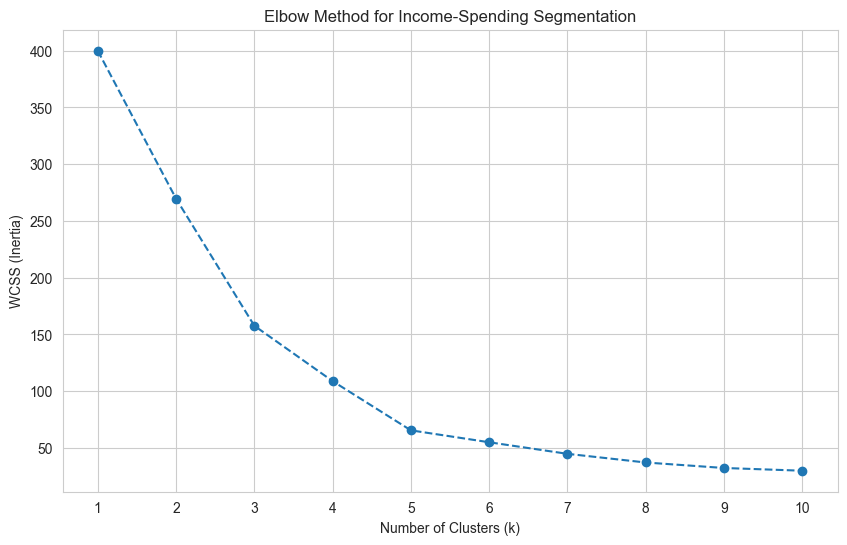

In [60]:
# 1. Select and scale the features
X1 = df[['Annual Income (k$)', 'Spending Score (1-100)']]
scaler1 = StandardScaler()
X1_scaled = scaler1.fit_transform(X1)

# 2. Implement the Elbow Method
wcss1 = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X1_scaled)
    wcss1.append(kmeans.inertia_)

# 3. Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss1, marker='o', linestyle='--')
plt.title('Elbow Method for Income-Spending Segmentation')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.xticks(range(1, 11))
plt.show()

Imagine you've grouped your friends into different clubs (these are your clusters). WCSS helps you figure out how "together" or "spread out" the members are within each club.

Cluster: This is one of the groups you've formed.
Centroid: This is the "center point" of a cluster. Think of it as the average location of all the members in that club.
WCSS: For each cluster, you calculate the distance from every member in that cluster to the cluster's centroid. Then you square all these distances and add them up. You do this for all the clusters and add up the totals.
A low WCSS means that the points within each cluster are very close to their centroid. This suggests that the clusters are tight and well-defined.

A high WCSS means that the points within each cluster are more spread out from their centroid, indicating less distinct or looser clusters.

How WCSS relates to K-Means:

In K-Means, the algorithm's goal is to minimize the WCSS. It tries to find the best locations for the centroids and the best groupings of points so that the total WCSS is as small as possible.

The Elbow Method, which you saw in the notebook, uses WCSS to help choose the optimal number of clusters (k) for K-Means. You calculate the WCSS for different values of k and look for the "elbow" where the decrease in WCSS starts to slow down. This point suggests that adding more clusters doesn't significantly improve the "tightness" of the clusters.

**Observation:** The "elbow" of the curve is clearly at **k=5**. The WCSS decreases sharply until k=5, and then the rate of decrease flattens out. This confirms our visual intuition from the scatter plot!

In [61]:
# Build and fit the final model
kmeans1 = KMeans(n_clusters=5, init='k-means++', random_state=42, n_init=10)
df['Income_Cluster'] = kmeans1.fit_predict(X1_scaled)

#### 3.1 Visualizing and Interpreting the Income-Based Segments

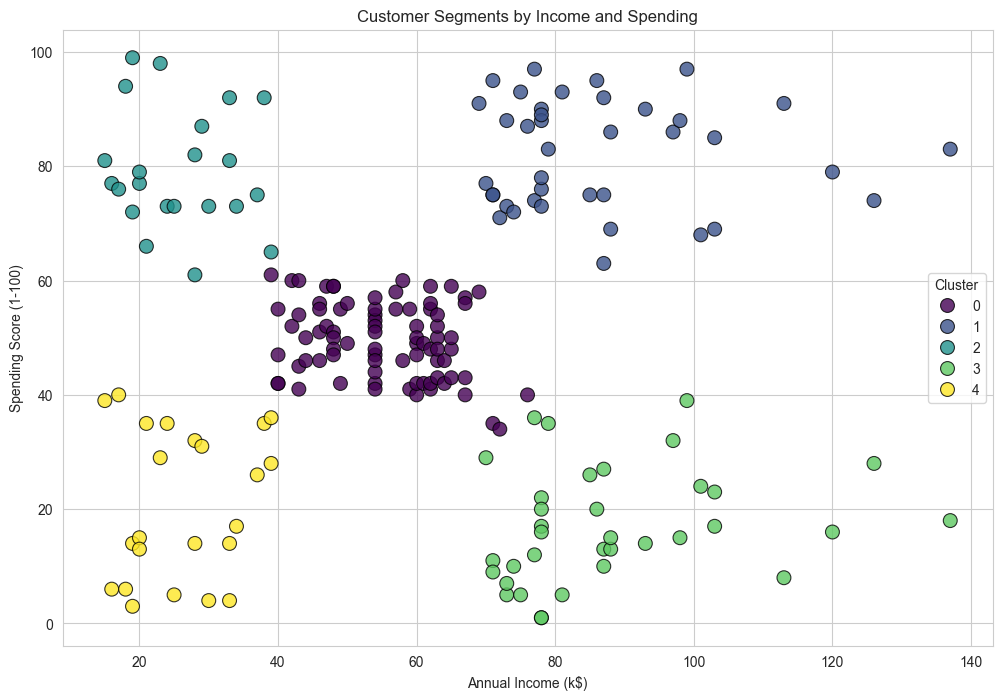

In [62]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='Annual Income (k$)', y='Spending Score (1-100)',
                hue='Income_Cluster', palette='viridis', s=100, alpha=0.8, edgecolor='black')
plt.title('Customer Segments by Income and Spending')
plt.legend(title='Cluster')
plt.show()

In [63]:
# Quantitative Persona Analysis
cluster_profiles1 = df.groupby('Income_Cluster')[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].mean().round(2)
cluster_profiles1['Size'] = df['Income_Cluster'].value_counts()
print("--- Income-Based Cluster Profiles ---")
cluster_profiles1

--- Income-Based Cluster Profiles ---


,Age,Annual Income (k$),Spending Score (1-100),Size
Income_Cluster,,,,
0,42.72,55.30,49.52,81
1,32.69,86.54,82.13,39
2,25.27,25.73,79.36,22
3,41.11,88.20,17.11,35
4,45.22,26.30,20.91,23


#### 3.2 Income-Based Personas and Strategy
Using the quantitative profiles, we can define our segments:
- **Cluster 0 (Careful High-Earners):** High income (~88k) but low spending (~17). Cautious, value-driven buyers.
- **Cluster 1 (Standard):** Average income (~55k) and spending (~50). This is the largest, core customer group.
- **Cluster 2 (Budget Shoppers):** Low income (~26k) and low spending (~21). Highly price-sensitive.
- **Cluster 3 (Target - High Value):** High income (~87k) and high spending (~82). The mall's prime target.
- **Cluster 4 (Enthusiasts):** Low income (~26k) but high spending (~79). Likely young, trend-focused shoppers.

### Step 4: Segmentation Model 2 - Age & Spending Score
Let's create a different segmentation model to see if we can find age-related customer groups.

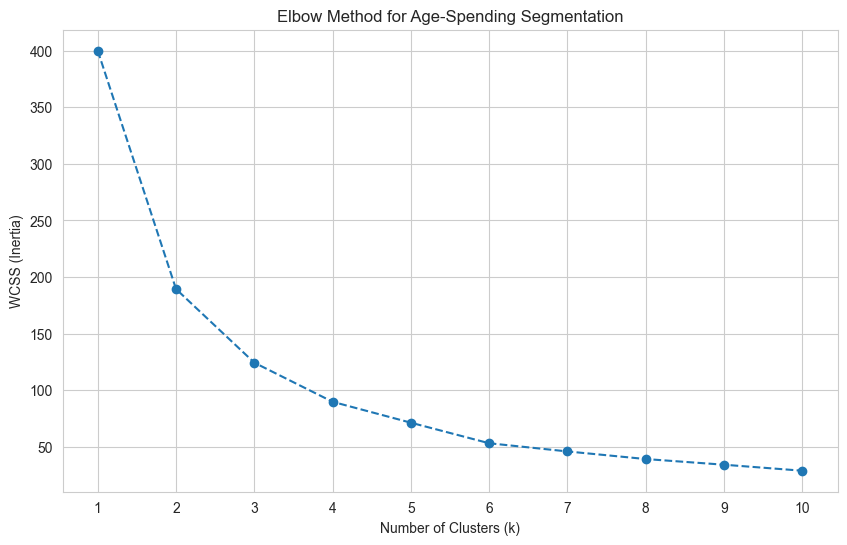

In [64]:
# 1. Select and scale the features
X2 = df[['Age', 'Spending Score (1-100)']]
scaler2 = StandardScaler()
X2_scaled = scaler2.fit_transform(X2)

# 2. Implement the Elbow Method
wcss2 = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X2_scaled)
    wcss2.append(kmeans.inertia_)

# 3. Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss2, marker='o', linestyle='--')
plt.title('Elbow Method for Age-Spending Segmentation')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.xticks(range(1, 11))
plt.show()

**Observation:** The elbow is less sharp here, but **k=4** appears to be a reasonable choice.

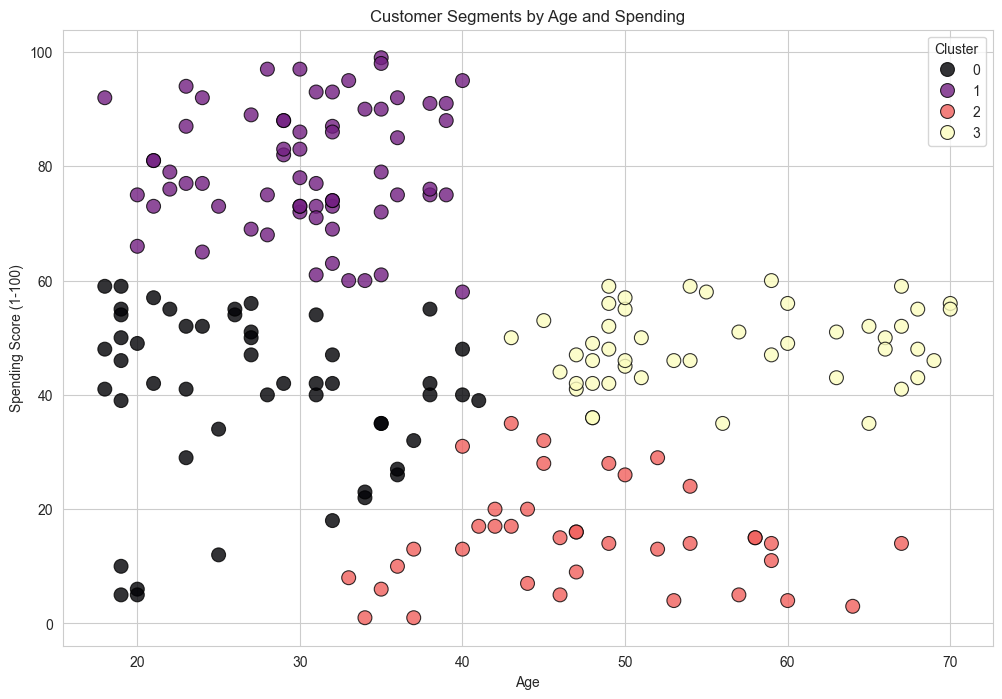

In [65]:
# Build and fit the final model for age segmentation
kmeans2 = KMeans(n_clusters=4, init='k-means++', random_state=42, n_init=10)
df['Age_Cluster'] = kmeans2.fit_predict(X2_scaled)

# Visualize the new clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='Age', y='Spending Score (1-100)',
                hue='Age_Cluster', palette='magma', s=100, alpha=0.8, edgecolor='black')
plt.title('Customer Segments by Age and Spending')
plt.legend(title='Cluster')
plt.show()

#### 4.1 Interpreting the Age-Based Segments
This model gives us a different perspective:
- **Young High-Spenders:** A clear group of customers under 40 with high spending scores.
- **Young Low-Spenders:** Customers under 40 with low-to-moderate spending.
- **Older Average-Spenders:** Customers over 40 with moderate spending scores.
- **Older Low-Spenders:** A small group of older customers with very low spending scores.

### Step 5: An Alternative Method - Hierarchical Clustering
To add more depth, let's briefly look at another clustering technique.

#### **Theoretical Concept: Hierarchical Clustering & Dendrograms**
Unlike K-Means, Hierarchical Clustering doesn't require us to specify the number of clusters beforehand. It builds a tree-like hierarchy of clusters.

We can visualize this hierarchy with a **dendrogram**. The dendrogram shows how clusters are merged (or split). To find the optimal number of clusters, we look for the tallest vertical line that doesn't cross any horizontal lines and draw a horizontal line through it. The number of vertical lines our new line crosses is the optimal number of clusters.


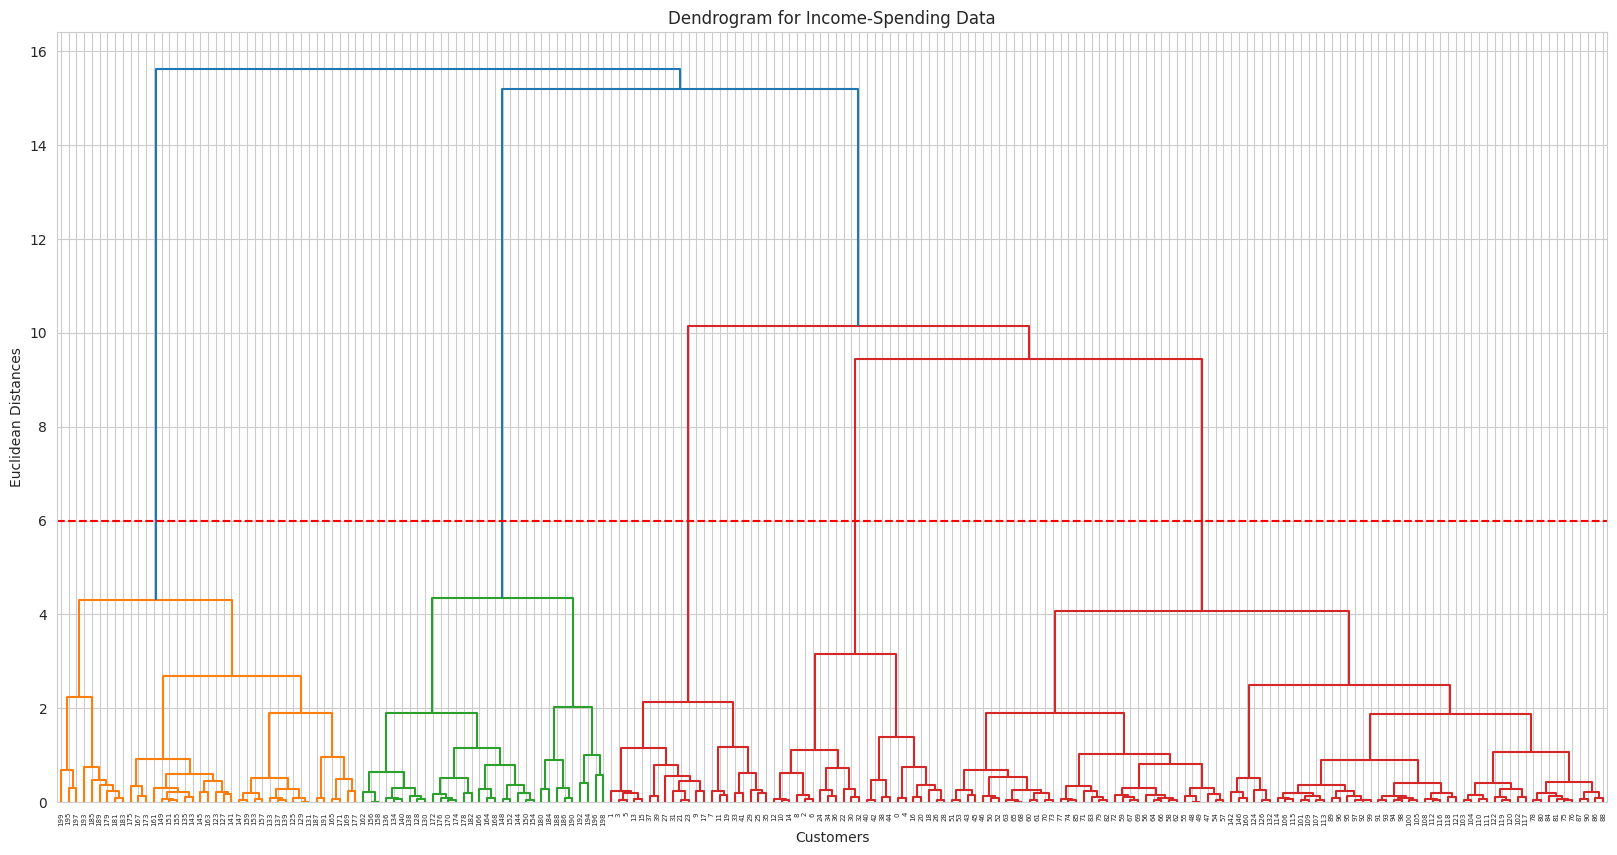

In [ ]:
plt.figure(figsize=(20, 10))
dendrogram = sch.dendrogram(sch.linkage(X1_scaled, method='ward'))
plt.title('Dendrogram for Income-Spending Data')
plt.xlabel('Customers')
plt.ylabel('Euclidean Distances')
plt.axhline(y=6, color='r', linestyle='--') # Example cut-off line
plt.show()

**Insight:** The dendrogram also confirms that **5 clusters** is the optimal number for the income-spending data. If we draw a horizontal line at a height of 6 (as shown by the red dashed line), it crosses five vertical lines.

### Step 6: Conclusion

In this extended project, we successfully applied unsupervised machine learning to perform customer segmentation.

**Key Steps Undertaken:**
1.  **Performed an in-depth EDA:** Used 2D and 3D plots to explore customer data from multiple angles.
2.  **Built two distinct segmentation models:** Created an income-based model and an age-based model, showing that segmentation is not a one-size-fits-all process.
3.  **Used the Elbow Method** to programmatically determine the optimal number of clusters for each scenario.
4.  **Introduced Hierarchical Clustering** as an alternative method and used its dendrogram to validate our choice of `k`.
5.  **Created quantitative, data-driven personas** for each segment, providing the marketing team with precise, actionable insights for targeted campaigns.

This project highlights how different clustering approaches can uncover different facets of customer behavior, providing a richer, more nuanced understanding than a single model alone.

### Submission Criteria

Based on the project objectives and the insights gained from the initial analysis, here are the key criteria for your submission:

1.  **Explore Gender vs. Spending Score:** Analyze the relationship between 'Gender' and 'Spending Score (1-100)' to see if gender plays a significant role in spending habits. Visualizations and summary statistics would be helpful here.
2.  **Apply Feature Engineering for Clustering:** Create a new feature using existing data (Feature Engineering). Then, explore if clustering can be effectively performed using this newly engineered feature in combination with one or more existing features. Document the feature engineering process, the chosen features for clustering, the determination of the optimal number of clusters (e.g., using the Elbow Method), and the resulting cluster visualization and interpretation.

1.  **Explore Gender vs. Spending Score:** Analyze the relationship between 'Gender' and 'Spending Score (1-100)' to see if gender plays a significant role in spending habits. Visualizations and summary statistics would be helpful here.

In [66]:
# Convert any remaining object columns to category type for one-hot encoding
print(f"Data shape before encoding: {df.shape}")
categorical_cols = df.select_dtypes(include=['object']).columns
df_new = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

print(f"Data shape after encoding: {df_new.shape}")

Data shape before encoding: (200, 6)
Data shape after encoding: (200, 6)


In [68]:
df=df.join(df_new['Gender_Male'])

In [71]:
df.head(10)

,Gender,Age,Annual Income (k$),Spending Score (1-100),Income_Cluster,Age_Cluster,Gender_Male
0,Male,19,15,39,4,0,True
1,Male,21,15,81,2,1,True
2,Female,20,16,6,4,0,False
3,Female,23,16,77,2,1,False
4,Female,31,17,40,4,0,False
5,Female,22,17,76,2,1,False
6,Female,35,18,6,4,2,False
7,Female,23,18,94,2,1,False
8,Male,64,19,3,4,2,True
9,Female,30,19,72,2,1,False


In [81]:
df['Gender_Male'].value_counts()

Gender_Male
False    112
True      88
Name: count, dtype: int64

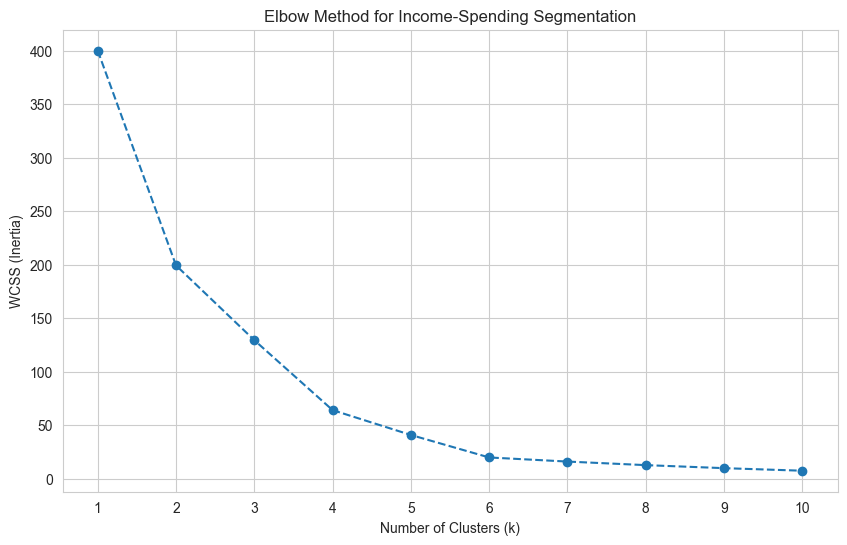

In [ ]:
# 1. Select and scale the features
X3 = df[['Gender_Male', 'Spending Score (1-100)']]
scaler1 = StandardScaler()
X3_scaled = scaler1.fit_transform(X3)

# 2. Implement the Elbow Method
wcss1 = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X3_scaled)
    wcss1.append(kmeans.inertia_)

# 3. Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss1, marker='o', linestyle='--')
plt.title('Elbow Method for Gender-Spending Segmentation')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.xticks(range(1, 11))
plt.show()

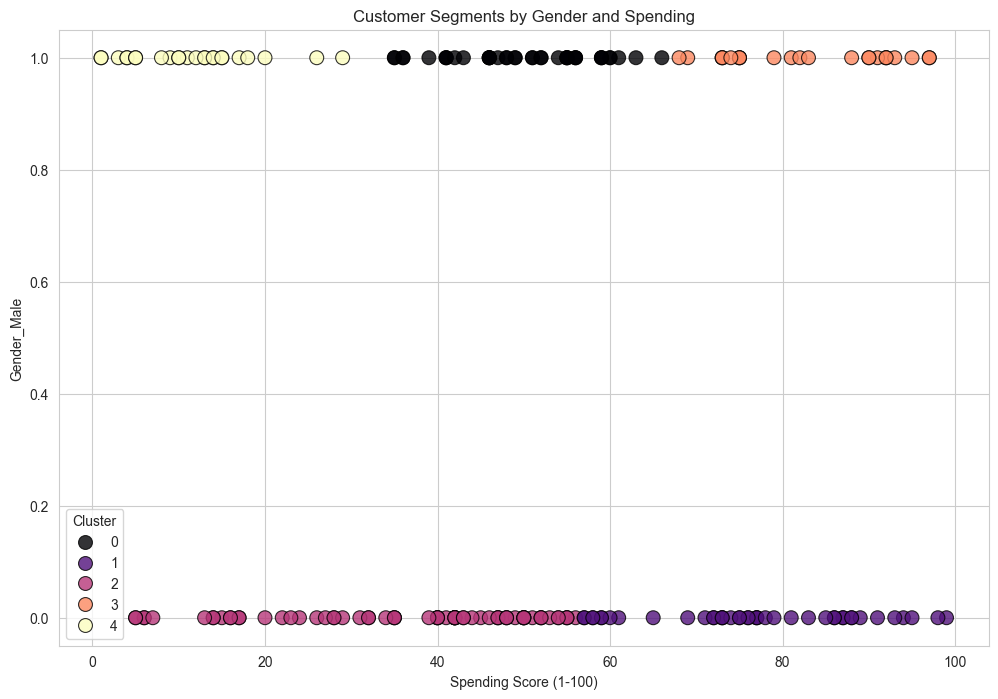

In [78]:




# Build and fit the final model for age segmentation
kmeans2 = KMeans(n_clusters=5, init='k-means++', random_state=42, n_init=10)
df['Gender_Cluster'] = kmeans2.fit_predict(X3_scaled)

# Visualize the new clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='Spending Score (1-100)', y='Gender_Male',
                hue='Gender_Cluster', palette='magma', s=100, alpha=0.8, edgecolor='black')
plt.title('Customer Segments by Gender and Spending')
plt.legend(title='Cluster')
plt.show()

Males have 3 clusters with low spending score(20), medium(30-65) and high(65-100) spending score while women are into 2 clusters high density of females medium spending score between (40 -55) while  another cluster with high spending score. When cluster are 6, majority of women have medium spending and high spending score.  Most of the customer spending money are females. So yes., gender plays a role in spending score.

| Cluster                  | Description                              | Gender Pattern                                              |
| ------------------------ | ---------------------------------------- | ----------------------------------------------------------- |
| **Cluster 4 (Yellow)**   | High spenders (scores 60–100)            | Mix of both genders, but slightly more females.             |
| **Cluster 2 (Red/Pink)** | Mid-range spenders (40–60)               | Balanced gender representation.                             |
| **Cluster 1 (Purple)**   | Low spenders (0–40)                      | Both males and females present, though slightly more males. |
| **Cluster 0 (Black)**    | Lowest spenders or conservative shoppers | Mostly males in this dataset.                               |
| **Cluster 3 (Magenta)**  | Moderate spenders                        | Gender distribution fairly balanced.                        |


No strong gender bias in spending patterns:
Both men and women appear across all clusters.
Spending clusters are not clearly separated by gender.

Slight trend:
Females are somewhat more represented in high-spending clusters (Cluster 4), while males dominate the low-spending clusters (Cluster 0).
But this pattern is not extreme — indicating that gender only mildly influences spending.

Cluster distribution shows that segmentation is more behavior-driven (spending habits) than demographic-driven (gender).

In [89]:
import pandas as pd
from scipy.stats import ttest_ind

# Load dataset
df_1= pd.read_csv("/Users/satta/Downloads/21-Days-21-Projects-Dataset/Datasets/Mall_Customers.csv")

# Encode gender (optional)
df_1['Gender_Male'] = df_1['Gender'].apply(lambda x: 1 if x == 'Male' else 0)

# Separate spending scores by gender
male_spending = df_1[df_1['Gender_Male'] == 1]['Spending Score (1-100)']
female_spending = df_1[df_1['Gender_Male'] == 0]['Spending Score (1-100)']

# Perform t-test
t_stat, p_val = ttest_ind(male_spending, female_spending, equal_var=False)

print("T-statistic:", t_stat)
print("P-value:", p_val)

if p_val < 0.05:
    print("✅ Significant difference in spending between genders.")
else:
    print("❌ No significant difference in spending between genders.")


T-statistic: -0.8048781809684525
P-value: 0.42199772447783646
❌ No significant difference in spending between genders.


2.  **Apply Feature Engineering for Clustering:** Create a new feature using existing data (Feature Engineering). Then, explore if clustering can be effectively performed using this newly engineered feature in combination with one or more existing features. Document the feature engineering process, the chosen features for clustering, the determination of the optimal number of clusters (e.g., using the Elbow Method), and the resulting cluster visualization and interpretation.

count    200.000000
mean       1.068544
std        0.973406
min        0.012821
25%        0.632803
50%        0.887993
75%        1.130245
max        5.400000
Name: Spending Score to Annual Income, dtype: float64


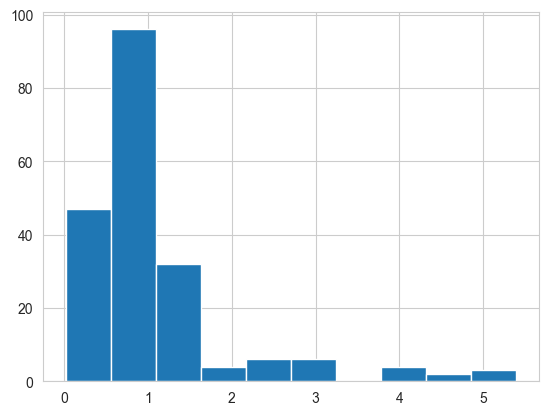

In [85]:
df['Spending Score to Annual Income'] = df['Spending Score (1-100)'] / df['Annual Income (k$)']
print(df['Spending Score to Annual Income'].describe())
df['Spending Score to Annual Income'].value_counts()
df['Spending Score to Annual Income'].hist()
plt.show()



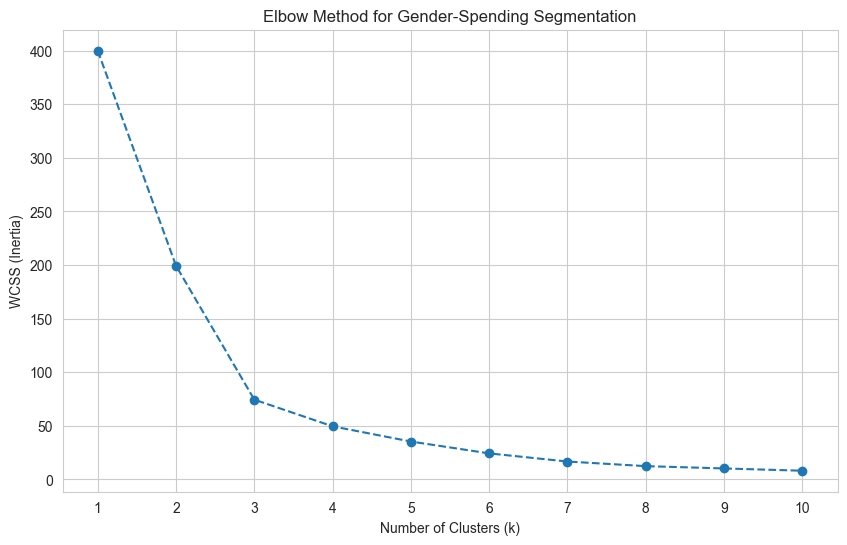

In [86]:
# 1. Select and scale the features
X4 = df[['Gender_Male', 'Spending Score to Annual Income']]
scaler1 = StandardScaler()
X4_scaled = scaler1.fit_transform(X4)

# 2. Implement the Elbow Method
wcss1 = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X4_scaled)
    wcss1.append(kmeans.inertia_)

# 3. Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss1, marker='o', linestyle='--')
plt.title('Elbow Method for Gender-Spending Segmentation')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.xticks(range(1, 11))
plt.show()

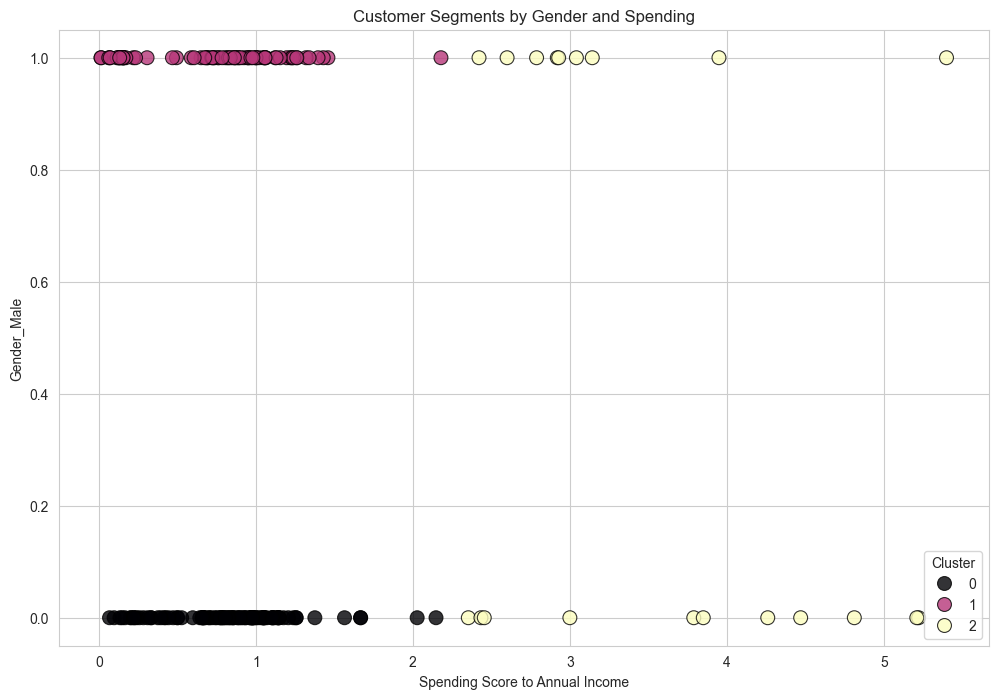

In [87]:
# Build and fit the final model for age segmentation
kmeans2 = KMeans(n_clusters=3, init='k-means++', random_state=42, n_init=10)
df['Spending Score to Annual Income_Cluster'] = kmeans2.fit_predict(X4_scaled)

# Visualize the new clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='Spending Score to Annual Income', y='Gender_Male',
                hue='Spending Score to Annual Income_Cluster', palette='magma', s=100, alpha=0.8, edgecolor='black')
plt.title('Customer Segments by Gender and Spending')
plt.legend(title='Cluster')
plt.show()

Income-to-spending ratio: Create a new feature that calculates the ratio of Spending Score to Annual Insights:

No strong gender-based differentiation in spending behavior:
The clusters are spread almost evenly between males (Gender_Male = 1) and females (Gender_Male = 0) across the “Spending Score to Annual Income” ratio.
➤ This suggests that gender alone does not significantly influence spending relative to income.

Spending behavior is driven more by income clusters than gender:
The three color-coded clusters (0, 1, 2) show that different customer segments exist based on spending-to-income ratio, but these segments are not gender-specific — both males and females appear in similar proportions within each cluster.

Possible interpretation of clusters:

Cluster 0 (black): Low spending relative to income — conservative spenders, both genders.

Cluster 1 (pink): Moderate spending group — mixed gender representation.

Cluster 2 (yellow): High spending relative to income — affluent or indulgent customers, again across both genders.

Group customers into age categories (bins) to see if adding this demographic factor improves cluster quality and interpretability.

In [96]:
from sklearn.metrics import silhouette_score
X_base = df[['Annual Income (k$)', 'Spending Score (1-100)']]
scaler = StandardScaler()
X_base_scaled = scaler.fit_transform(X_base)

# Run K-Means
kmeans_base = KMeans(n_clusters=5, random_state=42)
labels_base = kmeans_base.fit_predict(X_base_scaled)

# Compute silhouette score
silhouette_base = silhouette_score(X_base_scaled, labels_base)
print(f"Silhouette Score (before adding Age bins): {silhouette_base:.3f}")

Silhouette Score (before adding Age bins): 0.555


In [90]:

# Example bins and labels
bins = [0, 25, 35, 50, 70]
labels = ['Youth', 'Young Adult', 'Adult', 'Senior']

df['Age_Group'] = pd.cut(df['Age'], bins=bins, labels=labels)
df = pd.get_dummies(df, columns=['Age_Group'], drop_first=True)

In [99]:
# Select features including new age bins
X5_Scaled = df[['Annual Income (k$)', 'Spending Score (1-100)',
        'Age_Group_Young Adult', 'Age_Group_Adult', 'Age_Group_Senior']]

# Scale the data
scaler = StandardScaler()
X5_scaled = scaler.fit_transform(X5_Scaled)

# Run K-Means
kmeans = KMeans(n_clusters=5, random_state=42)
df['Cluster'] = kmeans.fit_predict(X5_scaled)

# Compute silhouette score
silhouette_new = silhouette_score(X5_scaled, df['Cluster'])
print(f"Silhouette Score (after adding Age bins): {silhouette_new:.3f}")

Silhouette Score (after adding Age bins): 0.473


Observation	Interpretation
Silhouette score drops after adding Age bins	The new feature(s) (like Age_Group) are not contributing to clearer separation between clusters.

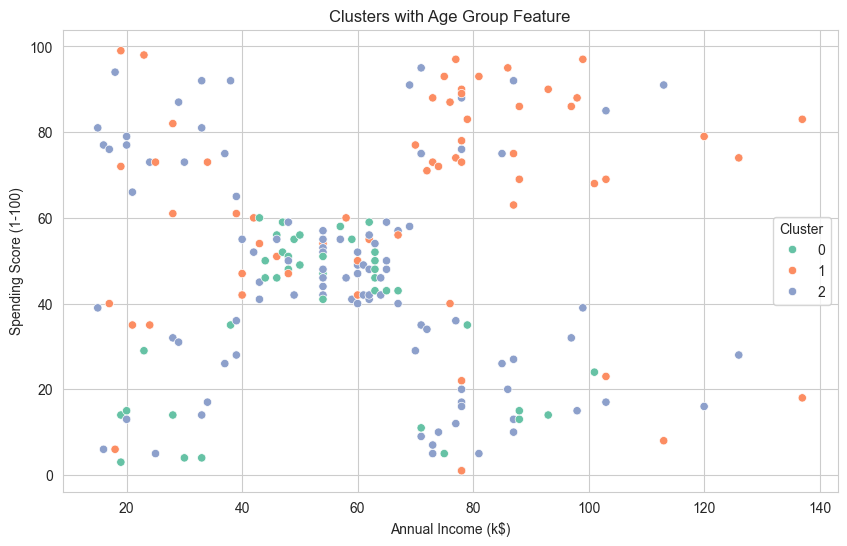

In [94]:

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Annual Income (k$)', y='Spending Score (1-100)',
                hue='Cluster', palette='Set2')
plt.title('Clusters with Age Group Feature')
plt.show()